# Steering MoE LLMs with Custom Datasets

In this tutorial, we show how to steer MoE LLMs using a custom dataset.
We focus on controlling whether the model outputs digits (1, 2, 3) or written numbers (one, two, three), and we can identify the relevant experts with just one example pair!

Steps:
1. Load a pre-trained MoE LLM.

2. Prepare a custom steering dataset.

3. Save routing activations on the dataset pairs.

4. Identify behavior-linked experts via risk difference.

5. (De)activate experts at inference to steer model behavior.

In [ ]:
# Copyright 2022 Adobe
# All Rights Reserved.

# NOTICE: Adobe permits you to use, modify, and distribute this file in
# accordance with the terms of the Adobe license agreement accompanying
# it.


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# os.environ["HF_HOME"] = "/data/tyler/dok/viola/cache" # use local cache at data/dok instead
os.environ["VLLM_ALLOW_INSECURE_SERIALIZATION"] = "1"
os.environ["VLLM_DISABLE_COMPILE_CACHE"] = "1"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TRUST_REMOTE_CODE"] = "true"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
os.environ["HF_TOKEN"] = "hf_xxxx"

os.environ["TEMP_NPY_BASE_PATH"] = "./temp_routings/"

import sys
import torch
import argparse
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm
from importlib import reload
from dotenv import load_dotenv
import huggingface_hub as hf_hub
from vllm import LLM, SamplingParams
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset, concatenate_datasets
from typing import Optional, List, Literal, Tuple, Dict

from src.utils import register_vllm_save_models, register_vllm_models, steer_moe

try:
    load_dotenv()
    hf_hub.login(os.environ["HF_TOKEN"])
except Exception as e:
    print("HF_TOKEN not found in environment variables. Continuing without login.")
    pass

if not os.path.exists(os.environ["TEMP_NPY_BASE_PATH"]):
    os.makedirs(os.environ["TEMP_NPY_BASE_PATH"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [11]:
# Constants
DATASET_NAME = "calibri"
CORRECT = "messages_correct" 
BUGGY = "messages_buggy"
THINKING_KEYWORDS = ("Wait, ", "This ", "Let me", "Still ", "No, ", "But ", "Actually, ")

# 1. Model

In [3]:
# Supported Models: 
# "Qwen/Qwen3-30B-A3B", "openai/gpt-oss-120b", 
# "microsoft/Phi-3.5-MoE-instruct", "openai/gpt-oss-20b", 
# "mistralai/Mixtral-8x7B-Instruct-v0.1", "allenai/OLMoE-1B-7B-0125-Instruct"
MODEL_NAME = "Qwen/Qwen3-30B-A3B"

register_vllm_save_models()
sampling_params = SamplingParams(temperature=0, top_p=0.8, top_k=1, min_p=0, max_tokens=1, seed=0)
llm = LLM(
    model=MODEL_NAME, 
    max_seq_len_to_capture=4000, max_model_len=4000, 
    tensor_parallel_size=torch.cuda.device_count(), gpu_memory_utilization=0.95, max_num_seqs=1,
    enforce_eager=True,
    enable_prefix_caching=False,
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

WARNING 02-12 13:57:05 [registry.py:458] Model architecture Qwen3MoeForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm_save.qwen3_moe:Qwen3MoeForCausalLM.
WARNING 02-12 13:57:05 [registry.py:458] Model architecture MixtralForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm_save.mixtral:MixtralForCausalLM.
WARNING 02-12 13:57:05 [registry.py:458] Model architecture OlmoeForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm_save.olmoe:OlmoeForCausalLM.
WARNING 02-12 13:57:05 [registry.py:458] Model architecture DeepseekV2ForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm_save.deepseek_v2:DeepseekV2ForCausalLM.
WARNING 02-12 13:57:05 [registry.py:458] Model architecture Llama4ForConditionalGeneration is already registered, and will be overwritten by the new model class src.modeling_vllm_save.mllama4:

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 02-12 13:57:13 [__init__.py:711] Resolved architecture: Qwen3MoeForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 02-12 13:57:13 [__init__.py:1750] Using max model len 4000
INFO 02-12 13:57:16 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 02-12 13:57:16 [scheduler.py:269] max_num_batched_tokens (8192) exceeds max_num_seqs * max_model_len (4000). This may lead to unexpected behavior.
WARNING 02-12 13:57:16 [scheduler.py:269] max_num_batched_tokens (8192) exceeds max_num_seqs * max_model_len (4000). This may lead to unexpected behavior.
INFO 02-12 13:57:16 [__init__.py:3565] Cudagraph is disabled under eager mode
WARNING 02-12 13:57:18 [serial_utils.py:48] Allowing insecure serialization using pickle due to VLLM_ALLOW_INSECURE_SERIALIZATION=1
(EngineCore_0 pid=141192) INFO 02-12 13:57:18 [core.py:636] Waiting for init message from front-end.
(EngineCore_0 pid=141192) INFO 02-12 13:57:18 [core.py:74] Initializing a V1 LLM engine (v0.10.1.1) with config: model='Qwen/Qwen3-30B-A3B', speculative_config=None, tokenizer='Qwen/Qwen3-30B-A3B', skip_tokenizer_in

Loading safetensors checkpoint shards:   0% Completed | 0/16 [00:00<?, ?it/s]


(EngineCore_0 pid=141192) (VllmWorker TP0 pid=141214) INFO 02-12 13:57:34 [default_loader.py:262] Loading weights took 8.23 seconds
(EngineCore_0 pid=141192) (VllmWorker TP1 pid=141216) INFO 02-12 13:57:35 [default_loader.py:262] Loading weights took 8.91 seconds
(EngineCore_0 pid=141192) (VllmWorker TP0 pid=141214) INFO 02-12 13:57:35 [gpu_model_runner.py:2007] Model loading took 28.4571 GiB and 10.057455 seconds
(EngineCore_0 pid=141192) (VllmWorker TP1 pid=141216) INFO 02-12 13:57:36 [gpu_model_runner.py:2007] Model loading took 28.4571 GiB and 11.094837 seconds
(EngineCore_0 pid=141192) (VllmWorker TP1 pid=141216) WARNING 02-12 13:57:38 [fused_moe.py:727] Using default MoE config. Performance might be sub-optimal! Config file not found at ['/data/dok/viola/projects/calibration/SteerMoE/.venv/lib/python3.12/site-packages/vllm/model_executor/layers/fused_moe/configs/E=128,N=384,device_name=NVIDIA_RTX_6000_Ada_Generation.json']
(EngineCore_0 pid=141192) (VllmWorker TP0 pid=141214) WAR

(EngineCore_0 pid=141192) (VllmWorker TP1 pid=141216) WARNING 02-12 13:59:01 [cudagraph_dispatcher.py:101] cudagraph dispatching keys are not initialized. No cudagraph will be used.
(EngineCore_0 pid=141192) (VllmWorker TP0 pid=141214) WARNING 02-12 13:59:01 [cudagraph_dispatcher.py:101] cudagraph dispatching keys are not initialized. No cudagraph will be used.


In [4]:
def get_routings(messages):
    """
    Get the routing logits for the given messages.
    """
    for layer in range(500):
        TEMP_NPY_PATH = f"{os.environ['TEMP_NPY_BASE_PATH']}router_logits_L{layer}.npy"
        if os.path.exists(TEMP_NPY_PATH):
            os.remove(TEMP_NPY_PATH)
        
    outputs = llm.chat(messages, sampling_params, use_tqdm=False, chat_template_kwargs={"enable_thinking": False, "reasoning_effort": "low"})
    
    all_router_logits = []
    for layer in range(500):
        try:
            TEMP_NPY_PATH = f"{os.environ['TEMP_NPY_BASE_PATH']}router_logits_L{layer}.npy"
            router_logits = np.load(TEMP_NPY_PATH).astype(np.float16)
            all_router_logits.append(router_logits)
        except FileNotFoundError:
            continue

    all_router_logits = np.stack(all_router_logits, axis=0)  # (num_layers, num_tokens, n_experts)
    output = {
        "router_logits": all_router_logits.astype(np.float16),  # (num_layers, num_tokens, n_experts)
        "messages": messages,
        "prompt_token_ids": outputs[0].prompt_token_ids,
    }
    return output

messages = [
    [{"role": "user", "content": "Hello"},]
]
r = get_routings(messages)
print(r.keys(), len(r["prompt_token_ids"]))
r["router_logits"].shape, r["router_logits"][:2, :2, :2]

INFO 02-12 13:59:01 [chat_utils.py:470] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
dict_keys(['router_logits', 'messages', 'prompt_token_ids']) 13


((48, 13, 128),
 array([[[-4.062, -3.86 ],
         [-4.22 , -5.594]],
 
        [[-3.188, -4.594],
         [-4.97 , -4.688]]], dtype=float16))

# 2. Dataset

In [4]:
### - messages_0: The messages for the first behavior response (ex safe)
### - messages_1: The messages for the second behavior response (ex unsafe)
### - messages_0_target: The target string for the first behavior response (Which tokens to compare routings)
### - messages_1_target: The target string for the second behavior response (Which tokens to compare routings)
# DATASET_NAME = "custom_dataset"

custom_df_ds = pd.DataFrame([
    {
        "messages_0": [{"role": "user", "content": "Count to ten"}, {"role": "assistant", "content": "1, 2, 3, 4, 5, 6, 7, 8, 9, 10"}],
        "messages_1": [{"role": "user", "content": "Count to ten"}, {"role": "assistant", "content": "one, two, three, four, five, six, seven, eight, nine, ten"}],
        "messages_0_target": "1, 2, 3, 4, 5, 6, 7, 8, 9, 10",
        "messages_1_target": "one, two, three, four, five, six, seven, eight, nine, ten",
    },
])

custom_df_ds

,messages_0,messages_1,messages_0_target,messages_1_target
0,"[{'role': 'user', 'content': 'Count to ten'}, ...","[{'role': 'user', 'content': 'Count to ten'}, ...","1, 2, 3, 4, 5, 6, 7, 8, 9, 10","one, two, three, four, five, six, seven, eight..."


In [5]:
calibri = load_dataset("lavis-nlp/CALIBRI", "livecodebench_qwen3")

In [12]:
def has_correct_and_buggy_program(example):
    correct, buggy = False, False
    for idx, program in enumerate(example['program']):
        if program != "" and not program.lstrip().startswith(THINKING_KEYWORDS):
            if example['is_correct'][idx]:  
                correct = True  
            if not example['is_correct'][idx]:  
                buggy = True   
            if correct and buggy:
                return True
    return False


calibri_filtered = calibri.filter(has_correct_and_buggy_program) #, load_from_cache_file=False)

print(f"After filtering: {len(calibri_filtered['train'])} train, {len(calibri_filtered['validation'])} val & {len(calibri_filtered['test'])} test examples.")


Filter:   0%|          | 0/527 [00:00<?, ? examples/s]

Filter:   0%|          | 0/264 [00:00<?, ? examples/s]

Filter:   0%|          | 0/264 [00:00<?, ? examples/s]

After filtering: 94 train, 51 val & 49 test examples.


In [13]:
#sys.path.insert(0, os.path.join(os.getcwd(), ".."))
#sys.path.insert(0, os.path.join(os.getcwd(), "../LiveCodeBench"))
#from lcb_runner.prompts.code_generation import format_prompt_generation

def get_lcb_generation_prompt(example):
    prompt = "You will be given a question (problem specification) and will generate a correct Python program that matches the specification and passes all tests. You will NOT return anything except for the program.\n\n"
    prompt += f"Question:\n{example['prompt']}\n\n"

    prompt += "Read the inputs from stdin solve the problem and write the answer to stdout (do not directly test on the sample inputs). Enclose your code within delimiters as follows. Ensure that when the python program runs, it reads the inputs, runs the algorithm and writes output to STDOUT.\n\n"
    prompt += f"```python\n# YOUR CODE HERE\n```\n\n"

    return prompt



In [14]:


# Map to pairs of buggy & correct

ds_pairs = {}

for split in calibri_filtered.keys():
    pairs_list = []
    for example in calibri_filtered[split]:
        correct = []
        buggy = []
        for prog_idx, program in enumerate(example['program']):
            if program != "" and not program.lstrip().startswith(THINKING_KEYWORDS):
                if example['is_correct'][prog_idx]:  
                    correct.append(program) #example['output'][prog_idx])
                else:  
                    buggy.append(program) #example['output'][prog_idx])
                    
        
        # TODO 
        # benchmark prompt (!!!) 
        # randomly selected programs
        # time whole output vs code only
        num_pairs = min(len(correct), len(buggy))
        for idx in range(num_pairs):

            pairs_list.append({
                    "id": f"{example['id']}_{idx}", 
                    CORRECT: [{"role": "user", "content": get_lcb_generation_prompt(example)}, 
                                {"role": "assistant", "content": correct[idx]}],
                    BUGGY: [{"role": "user", "content": get_lcb_generation_prompt(example)}, 
                                {"role": "assistant", "content": buggy[idx]}],
                    f"{CORRECT}_target": correct[idx],
                    f"{BUGGY}_target": buggy[idx],
                })


    ds_pairs[split] = Dataset.from_dict({
        "id": [p["id"] for p in pairs_list],
        CORRECT: [p[CORRECT] for p in pairs_list],
        BUGGY: [p[BUGGY] for p in pairs_list],
        f"{CORRECT}_target": [p[f"{CORRECT}_target"] for p in pairs_list],
        f"{BUGGY}_target": [p[f"{BUGGY}_target"] for p in pairs_list],
    })

print(f"Total pairs generated: {[(split, len(ds_pairs[split])) for split in ds_pairs]}")


ds_combined = concatenate_datasets([ds_pairs[split] for split in ds_pairs])
df_ds = pd.DataFrame(ds_combined)

df_ds.head()


Total pairs generated: [('train', 213), ('validation', 96), ('test', 119)]


,id,messages_correct,messages_buggy,messages_correct_target,messages_buggy_target
0,abc366_c_0,[{'content': 'You will be given a question (pr...,[{'content': 'You will be given a question (pr...,from collections import Counter\n\nQ = int(inp...,Q = int(input())\nbag = {} # Dictionary to st...
1,3226_0,[{'content': 'You will be given a question (pr...,[{'content': 'You will be given a question (pr...,"class Solution:\n def numberGame(self, nums...","class Solution:\n def numberGame(self, nums..."
2,abc397_c_0,[{'content': 'You will be given a question (pr...,[{'content': 'You will be given a question (pr...,"n = int(input())\na = list(map(int, input().sp...","n = int(input())\na = list(map(int, input().sp..."
3,abc397_c_1,[{'content': 'You will be given a question (pr...,[{'content': 'You will be given a question (pr...,"n = int(input())\na = list(map(int, input().sp...","n = int(input())\na = list(map(int, input().sp..."
4,abc382_d_0,[{'content': 'You will be given a question (pr...,[{'content': 'You will be given a question (pr...,"def backtrack(N, M, current_sequence, all_sequ...","def backtrack(N, M, current_sequence, results,..."


# 3. Save Routings

In [15]:


for PAIR_CHOICE in [CORRECT, BUGGY]:
    def find_sub_list(sl,l):
        results = []
        sll = len(sl)
        for ind in (i for i,e in enumerate(l) if e == sl[0]):
            if l[ind:ind+sll] == sl:
                results.append((ind, ind + sll - 1))
        return results

    
    outputs_list = []
    for i in tqdm(range(len(df_ds))):
        # Get routings
        messages = df_ds.iloc[i][PAIR_CHOICE]
        outputs = get_routings(messages)  # 'router_logits', 'messages', 'prompt_token_ids'
        # Check shapes
        num_layers, num_tokens, n_experts = outputs["router_logits"].shape
        assert num_tokens == len(outputs["prompt_token_ids"])
        # print(outputs["router_logits"].shape)
        # Store prompt tokens
        outputs["prompt_tokens"] = tokenizer.convert_ids_to_tokens(outputs["prompt_token_ids"], skip_special_tokens=False)
        outputs["prompt_tokens_special_mask"] = tokenizer.get_special_tokens_mask(
            outputs["prompt_token_ids"], already_has_special_tokens=True,
        )
        # Store the messages in a tokenized format
        outputs["messages_tokenized"] = [{
            "role": message["role"], 
            "content_token_ids": tokenizer(message["content"], add_special_tokens=False).input_ids,
            "content_tokens": tokenizer.convert_ids_to_tokens(tokenizer(message["content"], add_special_tokens=False).input_ids)
        } for message in messages]
        # Store the target texts and their tokenized forms (for detection comparison on these tokens)
        for col in [f"{PAIR_CHOICE}_target"]:
            target_text = df_ds.iloc[i][col]
            target_token_ids = tokenizer(df_ds.iloc[i][col], add_special_tokens=False).input_ids
            target_tokens = tokenizer.convert_ids_to_tokens(target_token_ids, skip_special_tokens=False)
            locations = find_sub_list(target_token_ids, outputs["prompt_token_ids"])
            if len(locations) == 0:
                # fallback: strip first token 
                locations = find_sub_list(target_token_ids[1:], outputs["prompt_token_ids"]) 
                print('Check:', df_ds.iloc[i]['id'], target_text[:50])

            
            assert len(locations) >= 1, f"Expected exactly one location: {locations}, for target text: \n{target_tokens}, in prompt tokens: \n{outputs['prompt_tokens']}"
            if len(locations) > 1:
                print(f"Expected exactly one location: {locations}, for target text: \n{target_tokens}, in prompt tokens: \n{outputs['prompt_tokens']}")
                print("Using last one")
                locations[0] = locations[-1]  # Use the last location if there are multiple
            outputs[col] = {
                "text": target_text,
                "tokens": target_tokens,
                "token_ids": target_token_ids,
                "start_idx": locations[0][0] if locations else None,
                "end_idx": locations[0][1] if locations else None,
            }
        # Append the outputs for this example to the list
        outputs_list.append(outputs)

    def get_model_num_experts(self):
        model = self.model_runner.model
        if hasattr(model, "model_config") and hasattr(model.model_config, "num_experts_per_tok"):
            return model.model_config.num_experts_per_tok  # gpt-oss
        elif hasattr(model.config, "num_experts_per_tok"):
            num_experts_per_tok = f"{model.config.num_experts_per_tok}"
        else:
            num_experts_per_tok = f"{model.config.text_config.num_experts_per_tok}"  # llama4
        return num_experts_per_tok
    num_experts_per_tok = llm.collective_rpc(get_model_num_experts)[0]

    df = pd.DataFrame(outputs_list)
    df.attrs = {
        "model_name": MODEL_NAME,
        "dataset_name": DATASET_NAME,
        "doc_choice": PAIR_CHOICE,
        "num_experts": n_experts,
        "num_experts_per_tok": num_experts_per_tok,
        "col_names": {},
    }
    path = f"output_[{MODEL_NAME.replace('/', '--')}]_[{DATASET_NAME}]_[{PAIR_CHOICE}]_[{len(df)}].pkl"
    df.to_pickle(path)
    print("### SAVED ROUTINGS AT:", path)
    print(len(df))
    print(df.attrs)
    df.head(2)

  0%|          | 0/428 [00:00<?, ?it/s]

### SAVED ROUTINGS AT: output_[Qwen--Qwen3-30B-A3B]_[calibri]_[messages_correct]_[428].pkl
428
{'model_name': 'Qwen/Qwen3-30B-A3B', 'dataset_name': 'calibri', 'doc_choice': 'messages_correct', 'num_experts': 128, 'num_experts_per_tok': '8', 'col_names': {}}


  0%|          | 0/428 [00:00<?, ?it/s]

Expected exactly one location: [(398, 406), (578, 586)], for target text: 
['f', 'da', 'Ċ', 'geb', 'Ċ', 'h', '*c', 'Ċ', 'i'], in prompt tokens: 
['<|im_start|>', 'user', 'Ċ', 'You', 'Ġwill', 'Ġbe', 'Ġgiven', 'Ġa', 'Ġquestion', 'Ġ(', 'problem', 'Ġspecification', ')', 'Ġand', 'Ġwill', 'Ġgenerate', 'Ġa', 'Ġcorrect', 'ĠPython', 'Ġprogram', 'Ġthat', 'Ġmatches', 'Ġthe', 'Ġspecification', 'Ġand', 'Ġpasses', 'Ġall', 'Ġtests', '.', 'ĠYou', 'Ġwill', 'ĠNOT', 'Ġreturn', 'Ġanything', 'Ġexcept', 'Ġfor', 'Ġthe', 'Ġprogram', '.ĊĊ', 'Question', ':Ċ', 'You', 'Ġare', 'Ġgiven', 'Ġa', 'Ġhorizontally', 'Ġwritten', 'Ġtext', '.', 'ĠConvert', 'Ġit', 'Ġto', 'Ġvertical', 'Ġwriting', ',', 'Ġfilling', 'Ġspaces', 'Ġwith', 'Ġ*', '.ĊĊ', 'You', 'Ġare', 'Ġgiven', 'ĠN', 'Ġstrings', 'ĠS', '_', '1', ',', 'ĠS', '_', '2', ',', 'Ġ\\', 'dots', ',', 'ĠS', '_N', 'Ġconsisting', 'Ġof', 'Ġlowercase', 'ĠEnglish', 'Ġletters', '.', 'ĠLet', 'ĠM', 'Ġbe', 'Ġthe', 'Ġmaximum', 'Ġlength', 'Ġof', 'Ġthese', 'Ġstrings', '.Ċ', 'Print', 'ĠM', '

# 4. Detect Experts

In [16]:
dfs = {
    CORRECT: pd.read_pickle(f"output_[{MODEL_NAME.replace('/', '--')}]_[{DATASET_NAME}]_[{CORRECT}]_[{len(df)}].pkl"),
    BUGGY: pd.read_pickle(f"output_[{MODEL_NAME.replace('/', '--')}]_[{DATASET_NAME}]_[{BUGGY}]_[{len(df)}].pkl"),
}

In [ ]:
TOKEN_REDUCE_FN = "rd"

def find_sub_list(sl,l, max_retries=1):
    num_retries = 0
    results = []
    sll = len(sl)
    for ind in (i for i,e in enumerate(l) if e == sl[0]):
        if l[ind:ind+sll] == sl:
            results.append((ind, ind + sll - 1))
    if len(results) == 0:
        num_retries += 1
        if num_retries <= max_retries:
            return find_sub_list(sl[1:], l, max_retries=max_retries-1) 
    return results  # [start_idx, end_idx]

def get_router_prob_n2(row):
    """Get the probability of each expert selected by the router for a given token."""
    router_logits = torch.tensor(row["router_logits"])  # (layer, token, expert)
    router_prob = torch.nn.functional.softmax(router_logits, dim=-1)  # (layer, token, expert)
    return router_prob.cpu().numpy()  # (layer, token, expert)

for key in tqdm(dfs.keys()):
    dfs[key]["router_prob_n2"] = dfs[key].apply(get_router_prob_n2, axis=1)  # (layer, token, expert)

# Concat router freq for all examples
freqs_collected = {CORRECT: [], BUGGY: []}
tokens = {CORRECT: [], BUGGY: []}

debug_example_starts = []
num_used_examples = 0
for row_idx in tqdm(range(0, len(dfs[CORRECT]))):
    router_prob_n2_1 = dfs[CORRECT].iloc[row_idx]["router_prob_n2"]  # (layer, token, expert)
    router_prob_n2_2 = dfs[BUGGY].iloc[row_idx]["router_prob_n2"]  # (layer, token, expert)
    num_tokens_1, num_tokens_2 = router_prob_n2_1.shape[1], router_prob_n2_2.shape[1]

    subset_1 = dfs[CORRECT].iloc[row_idx][f"{CORRECT}_target"]["token_ids"]
    subset_2 = dfs[BUGGY].iloc[row_idx][f"{BUGGY}_target"]["token_ids"]
    range_1 = find_sub_list(subset_1, dfs[CORRECT].iloc[row_idx]["prompt_token_ids"])
    range_2 = find_sub_list(subset_2, dfs[BUGGY].iloc[row_idx]["prompt_token_ids"])
    assert len(range_1) >= 1 and len(range_2) >= 1, f"Expected more than one range for each dataset, got {len(range_1)} and {len(range_2)}"
    range_1 = range_1[-1]
    range_2 = range_2[-1]
    num_used_examples += 1
    debug_example_starts.append(len(freqs_collected[CORRECT]))

    for token_1_idx in range(range_1[0], range_1[1] + 1):
        freqs_collected[CORRECT].append(router_prob_n2_1[:, token_1_idx, :])
        tokens[CORRECT].append(dfs[CORRECT].iloc[row_idx]['prompt_tokens'][token_1_idx])

    for token_2_idx in range(range_2[0], range_2[1] + 1):
        freqs_collected[BUGGY].append(router_prob_n2_2[:, token_2_idx, :])
        tokens[BUGGY].append(dfs[BUGGY].iloc[row_idx]['prompt_tokens'][token_2_idx])
    
    if len(freqs_collected[CORRECT]) > 2000000:
        print("Reached 2M token comparisons, stopping...")
        break

print(len(freqs_collected[CORRECT]))
freq = {CORRECT: np.stack(freqs_collected[CORRECT]), #
        BUGGY: np.stack(freqs_collected[BUGGY])}
print(f"freqencies correct: {freq[CORRECT].shape}, frequencies buggy: {freq[BUGGY].shape}")
print(f"Used examples: {num_used_examples}")

if "eq" in TOKEN_REDUCE_FN:
    # Equalize the number of tokens in both datasets
    # TODO this cuts hard to min tokens, check the comparison, may want to sample or pad 
    min_tokens = min(len(freq[CORRECT]), len(freq[BUGGY]))
    freq[CORRECT] = freq[CORRECT][-min_tokens:]
    freq[BUGGY] = freq[BUGGY][-min_tokens:]
    tokens[CORRECT] = tokens[CORRECT][-min_tokens:]
    tokens[BUGGY] = tokens[BUGGY][-min_tokens:]
    print(freq[CORRECT].shape, freq[BUGGY].shape)
# dfs['safe'].head(2)

  0%|          | 0/2 [00:00<?, ?it/s]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
key_df_1: messages_correct, key_df_2: messages_buggy


  0%|          | 0/428 [00:00<?, ?it/s]

10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
140012
(140012, 48, 128) (140432, 48, 128)
Used examples: 428
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"NULL\", \"type\": \"unknown\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"_pydevd_bundle.pydevd_constants.Null\"}]\n","stderr":"","mime":[]}
10{"stdout":"[{\"variableName\": \"ID_TO_MEANING\", \"type\": \"dictionary\", \"supportedEngines\": [\"pandas\"], \"isLocalVariable\": true, \"rawType\": \"builtins.dict\"}, {\"variableName\": \"N

In [19]:

TokenReduceMode = Literal["eq", "rd", "all"]


def find_subsequence(
    subsequence: List[int],
    sequence: List[int],
    max_retries: int = 1
) -> List[Tuple[int, int]]:
    """
    Find all occurrences of a subsequence within a sequence.
    
    Args:
        subsequence: The subsequence to find
        sequence: The sequence to search in
        max_retries: Number of retries if not found (tries with progressively shorter subsequence)
    
    Returns:
        List of (start_idx, end_idx) tuples for each occurrence
    """
    if not subsequence:
        return []
    
    results = []
    subseq_len = len(subsequence)
    
    # Find all occurrences
    for idx, element in enumerate(sequence[:-subseq_len + 1]):
        if element == subsequence[0]:
            if sequence[idx:idx + subseq_len] == subsequence:
                results.append((idx, idx + subseq_len - 1))
    
    # Retry with shorter subsequence if not found
    if len(results) == 0 and max_retries > 0:
        return find_subsequence(subsequence[1:], sequence, max_retries - 1)
    
    return results


def compute_router_probabilities(router_logits: List) -> np.ndarray:
    """
    Convert router logits to probabilities using softmax.
    
    Args:
        router_logits: Router logits from model (layer, token, expert)
    
    Returns:
        Router probabilities as numpy array (layer, token, expert)
    """
    logits_tensor = torch.tensor(router_logits)
    probabilities = torch.nn.functional.softmax(logits_tensor, dim=-1)
    return probabilities.cpu().numpy()


def extract_target_token_ranges(
    df: pd.DataFrame,
    split_name: str,
    row_idx: int
) -> Tuple[List[int], List[Tuple[int, int]]]:
    """
    Extract target token IDs and find their ranges in the prompt.
    
    Args:
        df: DataFrame containing the data
        split_name: Name of the split (CORRECT or BUGGY)
        row_idx: Row index to process
    
    Returns:
        Tuple of (target_token_ids, token_ranges)
    """
    row = df.iloc[row_idx]
    target_token_ids = row[f"{split_name}_target"]["token_ids"]
    prompt_token_ids = row["prompt_token_ids"]
    
    token_ranges = find_subsequence(target_token_ids, prompt_token_ids)
    
    if not token_ranges:
        raise ValueError(f"Target tokens not found in prompt for row {row_idx}, split {split_name}")
    
    return target_token_ids, token_ranges


def collect_router_data(
    dfs: Dict[str, pd.DataFrame],
    token_reduce_mode: TokenReduceMode = "all",
    max_tokens: int = 2_000_000
) -> Tuple[Dict[str, np.ndarray], Dict[str, List[str]], List[int]]:
    """
    Collect router probabilities and tokens from datasets.
    
    Args:
        dfs: Dictionary of DataFrames with keys CORRECT and BUGGY
        token_reduce_mode: How to reduce tokens:
            - "all": Use all tokens in target sequence
            - "rd": Use only last token per target sequence
            - "eq": Equalize token counts after collection
        max_tokens: Maximum number of tokens to collect before stopping
    
    Returns:
        Tuple of (router_probabilities, tokens, example_start_indices)
    """
    # Add router probabilities to dataframes
    print("Computing router probabilities...")
    for key in tqdm(dfs.keys()):
        dfs[key]["router_prob"] = dfs[key]["router_logits"].apply(
            compute_router_probabilities
        )
    
    # Initialize collection structures
    router_probs = {CORRECT: [], BUGGY: []}
    tokens = {CORRECT: [], BUGGY: []}
    example_starts = []
    num_examples = 0
    
    print("Collecting router data from examples...")
    for row_idx in tqdm(range(len(dfs[CORRECT]))):
        # Check token limit
        if len(router_probs[CORRECT]) > max_tokens:
            print(f"Reached {max_tokens:,} token comparisons, stopping...")
            break
        
        # Mark example start
        example_starts.append(len(router_probs[CORRECT]))
        num_examples += 1
        
        # Process both splits
        for split_name in [CORRECT, BUGGY]:
            router_prob = dfs[split_name].iloc[row_idx]["router_prob"]  # (layer, token, expert)
            prompt_tokens = dfs[split_name].iloc[row_idx]["prompt_tokens"]
            
            # Find target token ranges
            _, token_ranges = extract_target_token_ranges(dfs[split_name], split_name, row_idx)
            
            # Use the last occurrence of the target sequence
            start_idx, end_idx = token_ranges[-1]
                  
                
            # Determine which tokens to collect based on mode
            if token_reduce_mode == "rd":
                # Only collect the last token
                router_probs[split_name].append(router_prob[:, end_idx, :])
                tokens[split_name].append(prompt_tokens[end_idx])
            else:  # "all" or "eq"
                # Collect all tokens in the range (vectorized)
                # router_prob is (layer, token, expert)
                # We want each token to be a separate entry: (layer, expert)
                token_range = router_prob[:, start_idx:end_idx + 1, :]  # (layer, num_tokens, expert)
                
                # Transpose to (num_tokens, layer, expert) and convert to list
                for single_token_prob in token_range.transpose(1, 0, 2):
                    router_probs[split_name].append(single_token_prob)
                
                # Extend tokens list
                tokens[split_name].extend(prompt_tokens[start_idx:end_idx + 1])
    
    print(f"Collected {len(router_probs[CORRECT]):,} tokens from {num_examples} examples")
    
    # Stack into arrays
    stacked_probs = {
        CORRECT: np.stack(router_probs[CORRECT]),
        BUGGY: np.stack(router_probs[BUGGY])
    }
    
    # Equalize if requested
    if token_reduce_mode == "eq":
        stacked_probs, tokens = equalize_token_counts(stacked_probs, tokens)
    
    print(f"Final shapes - Correct: {stacked_probs[CORRECT].shape}, Buggy: {stacked_probs[BUGGY].shape}")
    print(f"Used {num_examples} examples")
    
    return stacked_probs, tokens, example_starts


def equalize_token_counts(
    router_probs: Dict[str, np.ndarray],
    tokens: Dict[str, List[str]]
) -> Tuple[Dict[str, np.ndarray], Dict[str, List[str]]]:
    """
    Equalize the number of tokens between CORRECT and BUGGY by keeping the last N tokens.
    
    Args:
        router_probs: Dictionary of router probability arrays
        tokens: Dictionary of token lists
    
    Returns:
        Tuple of (equalized_router_probs, equalized_tokens)
    """
    min_tokens = min(len(router_probs[CORRECT]), len(router_probs[BUGGY]))
    
    print(f"Equalizing to {min_tokens:,} tokens (keeping last tokens from each split)")
    
    equalized_probs = {
        CORRECT: router_probs[CORRECT][-min_tokens:],
        BUGGY: router_probs[BUGGY][-min_tokens:]
    }
    
    equalized_tokens = {
        CORRECT: tokens[CORRECT][-min_tokens:],
        BUGGY: tokens[BUGGY][-min_tokens:]
    }
    
    return equalized_probs, equalized_tokens



    
    # Mode 1: All tokens in target sequences
freq_all, tokens_all, starts_all = collect_router_data(
        dfs, 
        token_reduce_mode="all"
    )
    
    # Mode 2: Only last token per target sequence (rd = reduce)
freq_reduced, tokens_reduced, starts_reduced = collect_router_data(
        dfs, 
        token_reduce_mode="rd"
    )
    
    

Computing router probabilities...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/428 [00:00<?, ?it/s]

Collected 140,012 tokens from 428 examples
Final shapes - Correct: (140012, 48, 128), Buggy: (140432, 48, 128)
Used 428 examples
Computing router probabilities...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/428 [00:00<?, ?it/s]

Collected 428 tokens from 428 examples
Final shapes - Correct: (428, 48, 128), Buggy: (428, 48, 128)
Used 428 examples


In [18]:
from scipy.stats import ttest_rel

NUM_EXPERTS_PER_TOK = int(dfs[CORRECT].attrs["num_experts_per_tok"])
print(f"Number of experts per token: {NUM_EXPERTS_PER_TOK}")



def calc_risk_diff(prob1, prob2):
    ### prob1,2 = (batch, layer, expert)
    ### Count how many times each expert is activated
    a1, a2, d1, d2 = np.zeros((prob1.shape[1], prob1.shape[2])), np.zeros((prob2.shape[1], prob2.shape[2])), np.zeros((prob1.shape[1], prob1.shape[2])), np.zeros((prob2.shape[1], prob2.shape[2]))
    pre_processed_act1 = np.argsort(prob1, axis=-1)  # Get top experts
    pre_processed_act2 = np.argsort(prob2, axis=-1)  # Get top experts
    
    for token_idx in tqdm(range(prob1.shape[0])):
        for layer in range(prob1.shape[1]):
            activated_experts_1 = pre_processed_act1[token_idx, layer, -NUM_EXPERTS_PER_TOK:]  # Get top 8 experts
            a1[layer, activated_experts_1] += 1
            deactivated_experts_1 = pre_processed_act1[token_idx, layer, :-NUM_EXPERTS_PER_TOK]  # Experts not activated in prob1
            d1[layer, deactivated_experts_1] += 1
            assert len(activated_experts_1) + len(deactivated_experts_1) == prob1.shape[2]  # num experts
    
    for token_idx in tqdm(range(prob2.shape[0])):
        for layer in range(prob2.shape[1]):
            activated_experts_2 = pre_processed_act2[token_idx, layer, -NUM_EXPERTS_PER_TOK:]
            a2[layer, activated_experts_2] += 1
            deactivated_experts_2 = pre_processed_act2[token_idx, layer, :-NUM_EXPERTS_PER_TOK]  # Experts not activated in prob2
            d2[layer, deactivated_experts_2] += 1
            assert len(activated_experts_2) + len(deactivated_experts_2) == prob2.shape[2]  # num experts

    layer_expert_paired_ttest = []
    for layer in tqdm(range(prob1.shape[1])):
        for expert in range(prob1.shape[2]):
            test_results = {
                "layer": layer,
                "expert": expert,
                "a1": a1[layer, expert],
                "a2": a2[layer, expert],
                "d1": d1[layer, expert],
                "d2": d2[layer, expert],
                "a1_n": (a1[layer, expert] / (a1[layer, expert] + d1[layer, expert])),
                "a2_n": (a2[layer, expert] / (a2[layer, expert] + d2[layer, expert])),
                "risk_diff": (a1[layer, expert] / (a1[layer, expert] + d1[layer, expert])) - (a2[layer, expert] / (a2[layer, expert] + d2[layer, expert]))
            }
            layer_expert_paired_ttest.append(test_results)
    return pd.DataFrame(layer_expert_paired_ttest)


subset1, subset2 = CORRECT, BUGGY  # "random_doc"
df = calc_risk_diff(freq[subset1], freq[subset2])
df["Layer_Expert"] = df.apply(lambda x: f"L{int(x['layer']):02d}\nE{int(x['expert']):02d}", axis=1)

df["risk_diff_abs"] = df["risk_diff"].abs()
df = df.sort_values(by="risk_diff_abs", ascending=False).reset_index(drop=True)

path = f"activations_[{dfs[subset1].attrs['model_name'].replace('/', '--')}]_[{dfs[subset1].attrs['dataset_name']}]_[{TOKEN_REDUCE_FN}]_[{len(dfs[CORRECT])}]_[{len(freq[subset1])}].pkl"
df.to_pickle(path)
print(f"Saved to {path}")

df

Number of experts per token: 8


  0%|          | 0/67432 [00:00<?, ?it/s]

  0%|          | 0/68843 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Saved to activations_[Qwen--Qwen3-30B-A3B]_[calibri]_[rd]_[214]_[67432].pkl


,layer,expert,a1,a2,d1,d2,a1_n,a2_n,risk_diff,Layer_Expert,risk_diff_abs
0,12,88,39599.0,37491.0,27833.0,31352.0,0.587243,0.544587,0.042656,L12\nE88,0.042656
1,28,61,36697.0,34778.0,30735.0,34065.0,0.544207,0.505178,0.039029,L28\nE61,0.039029
2,24,88,32286.0,30302.0,35146.0,38541.0,0.478793,0.440161,0.038633,L24\nE88,0.038633
3,2,26,40142.0,38416.0,27290.0,30427.0,0.595296,0.558023,0.037273,L02\nE26,0.037273
4,33,3,34989.0,33208.0,32443.0,35635.0,0.518878,0.482373,0.036505,L33\nE03,0.036505
...,...,...,...,...,...,...,...,...,...,...,...
6139,0,55,0.0,0.0,67432.0,68843.0,0.000000,0.000000,0.000000,L00\nE55,0.000000
6140,0,15,0.0,0.0,67432.0,68843.0,0.000000,0.000000,0.000000,L00\nE15,0.000000
6141,47,91,0.0,0.0,67432.0,68843.0,0.000000,0.000000,0.000000,L47\nE91,0.000000
6142,0,10,0.0,0.0,67432.0,68843.0,0.000000,0.000000,0.000000,L00\nE10,0.000000


In [21]:
NUM_EXPERTS_PER_TOK = int(dfs[CORRECT].attrs["num_experts_per_tok"])
print(f"Number of experts per token: {NUM_EXPERTS_PER_TOK}")


def calc_risk_diff(
    prob1, 
    prob2, 
    num_experts_per_tok=NUM_EXPERTS_PER_TOK,
    token_ids1=None,
    token_ids2=None,
    filter_mode: Literal["all", "last", "special_tokens"] = "all",
    special_token_ids: Optional[List[int]] = None
):
    """
    Calculate risk difference for expert activation between two probability distributions.
    
    Args:
        prob1: Array of shape (batch1, layer, expert) - first probability distribution
        prob2: Array of shape (batch2, layer, expert) - second probability distribution
        num_experts_per_tok: Number of top experts to consider as "activated"
        token_ids1: Array of shape (batch1,) containing token IDs for prob1
        token_ids2: Array of shape (batch2,) containing token IDs for prob2
        filter_mode: How to filter tokens:
            - "all": Use all tokens (default)
            - "last": Use only the last token in the sequence
            - "special_tokens": Use only tokens matching special_token_ids
        special_token_ids: List of token IDs to filter for (required if filter_mode="special_tokens")
    
    Returns:
        DataFrame with risk difference statistics per layer and expert
    """
    batch_size1, num_layers1, num_experts1 = prob1.shape
    batch_size2, num_layers2, num_experts2 = prob2.shape
    
    # Validate that layers and experts match
    assert num_layers1 == num_layers2, f"Number of layers must match: {num_layers1} != {num_layers2}"
    assert num_experts1 == num_experts2, f"Number of experts must match: {num_experts1} != {num_experts2}"
    
    num_layers = num_layers1
    num_experts = num_experts1
    
    if filter_mode == "special_tokens":
        assert special_token_ids is not None, "special_token_ids required when filter_mode='special_tokens'"
        assert token_ids1 is not None and token_ids2 is not None, "token_ids1 and token_ids2 required when filter_mode='special_tokens'"
    
    # Create separate masks for each probability distribution
    mask1 = create_token_mask(batch_size1, token_ids1, filter_mode, special_token_ids)
    mask2 = create_token_mask(batch_size2, token_ids2, filter_mode, special_token_ids)
    
    # Get top experts (vectorized)
    top_experts_1 = np.argsort(prob1, axis=-1)[..., -num_experts_per_tok:]
    top_experts_2 = np.argsort(prob2, axis=-1)[..., -num_experts_per_tok:]
    
    # Count activations separately for each distribution
    a1 = count_activations_vectorized(top_experts_1, num_layers, num_experts, mask1)
    a2 = count_activations_vectorized(top_experts_2, num_layers, num_experts, mask2)
    
    # Count total tokens after filtering (can be different!)
    total_tokens1 = np.sum(mask1)
    total_tokens2 = np.sum(mask2)
    
    # Count deactivations
    d1 = total_tokens1 - a1
    d2 = total_tokens2 - a2
    
    # Calculate risk differences with proper normalization
    eps = 1e-10
    a1_normalized = a1 / (total_tokens1 + eps)
    a2_normalized = a2 / (total_tokens2 + eps)
    risk_diff = a1_normalized - a2_normalized
    
    # Create results dataframe efficiently
    layer_indices = np.repeat(np.arange(num_layers), num_experts)
    expert_indices = np.tile(np.arange(num_experts), num_layers)
    
    results_df = pd.DataFrame({
        "layer": layer_indices,
        "expert": expert_indices,
        "a1": a1.ravel(),
        "a2": a2.ravel(),
        "d1": d1.ravel(),
        "d2": d2.ravel(),
        "a1_n": a1_normalized.ravel(),
        "a2_n": a2_normalized.ravel(),
        "risk_diff": risk_diff.ravel(),
    })
    
    return results_df


def create_token_mask(
    batch_size: int,
    token_ids: Optional[np.ndarray],
    filter_mode: str,
    special_token_ids: Optional[List[int]]
) -> np.ndarray:
    """
    Create a boolean mask for which tokens to include in the analysis.
    """
    if filter_mode == "all":
        return np.ones(batch_size, dtype=bool)
    
    elif filter_mode == "last":
        mask = np.zeros(batch_size, dtype=bool)
        mask[-1] = True
        return mask
    
    elif filter_mode == "special_tokens":
        mask = np.isin(token_ids, special_token_ids)
        return mask
    
    else:
        raise ValueError(f"Unknown filter_mode: {filter_mode}")


def count_activations_vectorized(
    top_experts: np.ndarray,
    num_layers: int,
    num_experts: int,
    mask: np.ndarray
) -> np.ndarray:
    """
    Count activations using vectorized numpy operations.
    
    Args:
        top_experts: Array of shape (batch, layer, num_experts_per_tok)
        num_layers: Number of layers
        num_experts: Total number of experts
        mask: Boolean array of shape (batch,) indicating which tokens to count
    
    Returns:
        Array of shape (layer, expert) with activation counts
    """
    # Filter to only masked tokens
    filtered_experts = top_experts[mask]
    
    if filtered_experts.shape[0] == 0:
        return np.zeros((num_layers, num_experts), dtype=np.int32)
    
    counts = np.zeros((num_layers, num_experts), dtype=np.int32)
    
    # For each layer, count expert activations
    for layer in range(num_layers):
        # Get all expert activations for this layer across all filtered tokens
        layer_experts = filtered_experts[:, layer, :]
        
        # Flatten to 1D array of expert indices
        expert_indices = layer_experts.ravel()
        
        # Count occurrences using bincount
        layer_counts = np.bincount(expert_indices, minlength=num_experts)
        counts[layer, :] = layer_counts
    
    return counts




Number of experts per token: 8


Saved to activations_[Qwen--Qwen3-30B-A3B]_[calibri]_[all]_[428]_[140012].pkl


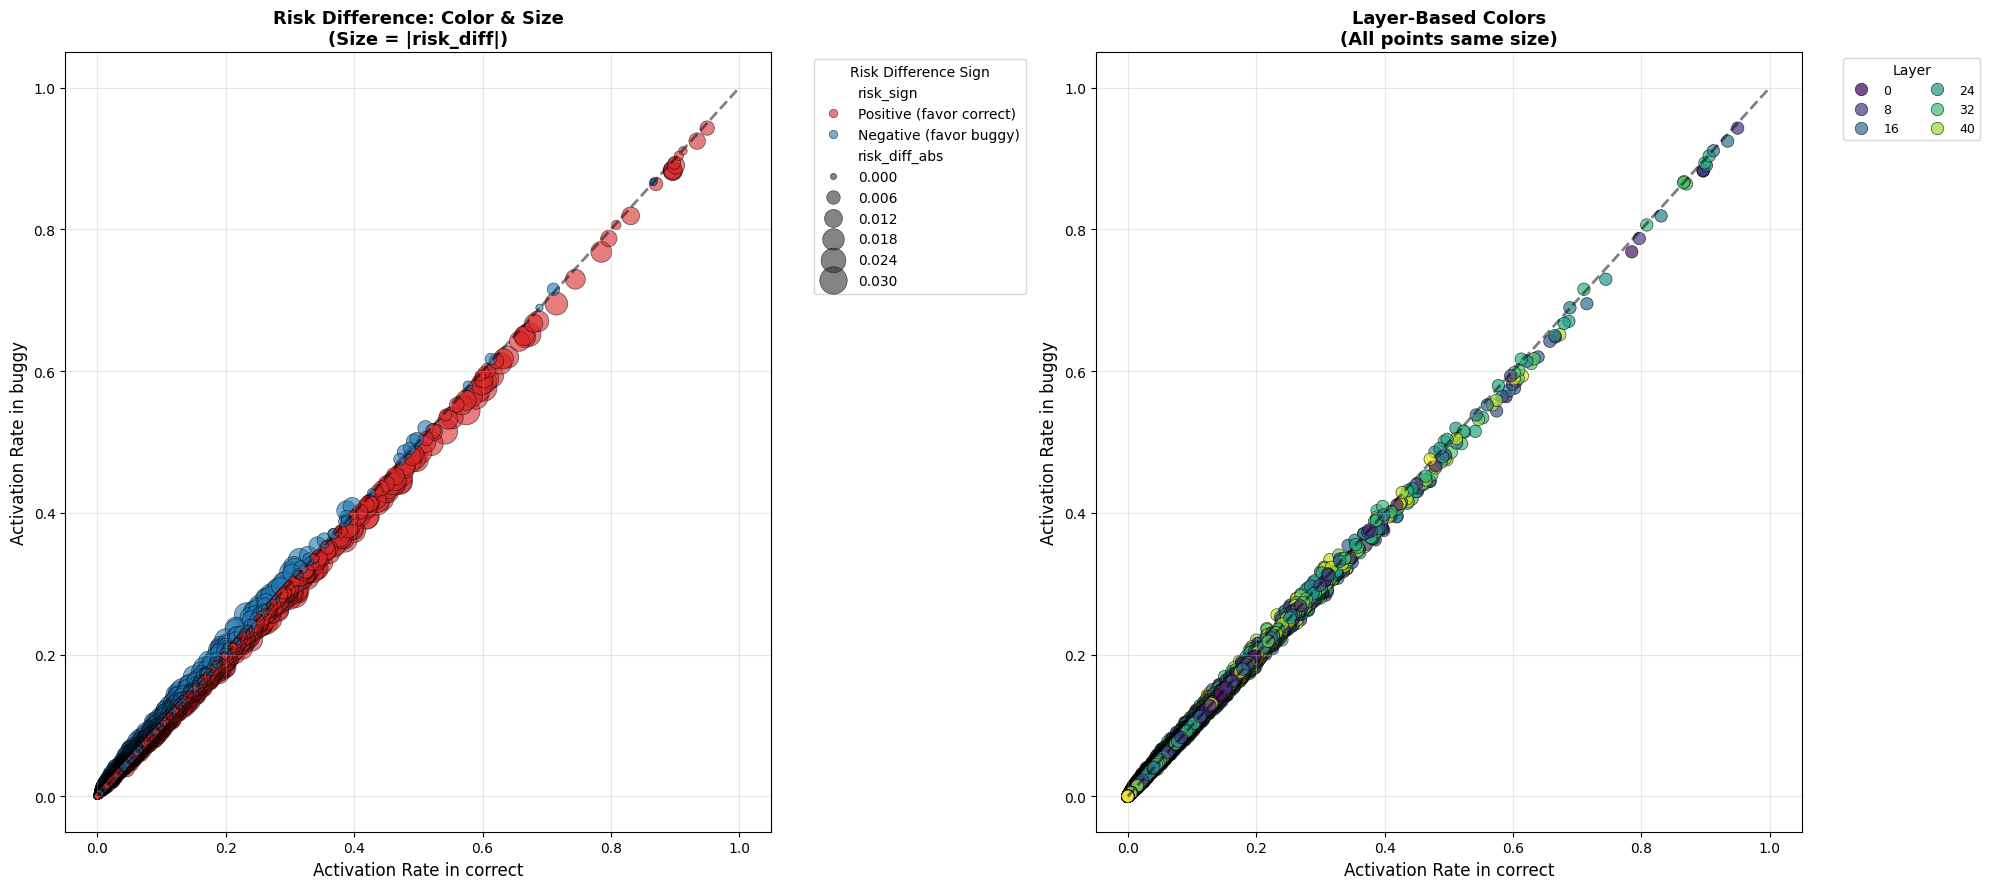

,layer,expert,a1,a2,d1,d2,a1_n,a2_n,risk_diff,risk_diff_abs
0,12,88,80436,76352,59576,64080,0.574494,0.543694,0.030800,0.030800
1,24,88,65930,62392,74082,78040,0.470888,0.444286,0.026602,0.026602
2,13,22,84326,80853,55686,59579,0.602277,0.575745,0.026532,0.026532
3,28,61,75779,72316,64233,68116,0.541232,0.514954,0.026278,0.026278
4,16,61,65802,62431,74210,78001,0.469974,0.444564,0.025410,0.025410
5,2,26,82485,79194,57527,61238,0.589128,0.563931,0.025197,0.025197
6,25,46,58749,55473,81263,84959,0.419600,0.395017,0.024583,0.024583
7,21,3,58603,55366,81409,85066,0.418557,0.394255,0.024302,0.024302
8,7,81,43122,39842,96890,100590,0.307988,0.283710,0.024278,0.024278
9,22,79,55823,52649,84189,87783,0.398702,0.374907,0.023794,0.023794


In [23]:
def process_activation_counts(freq_1, 
                              freq_2, 
                              filter_mode:Literal["all", "last", "special_tokens"]='all',
                              plot_diffs=False):
    
    df = calc_risk_diff(freq_1, freq_2, filter_mode=filter_mode)
    df["risk_diff_abs"] = df["risk_diff"].abs()
    df = df.sort_values(by="risk_diff_abs", ascending=False).reset_index(drop=True)

    path = f"activations_[{dfs[CORRECT].attrs['model_name'].replace('/', '--')}]_[{dfs[CORRECT].attrs['dataset_name']}]_[{filter_mode}]_[{len(dfs[CORRECT])}]_[{len(freq[CORRECT])}].pkl"
    df.to_pickle(path)
    print(f"Saved to {path}")
    if plot_diffs:
        plot_a1n_vs_a2n(df, 'correct', 'buggy')
    
    return df

df = process_activation_counts(freq[CORRECT], freq[BUGGY], filter_mode="all", plot_diffs=True)

df.head(10)

Saved to activations_[Qwen--Qwen3-30B-A3B]_[calibri]_[all]_[428]_[140012].pkl


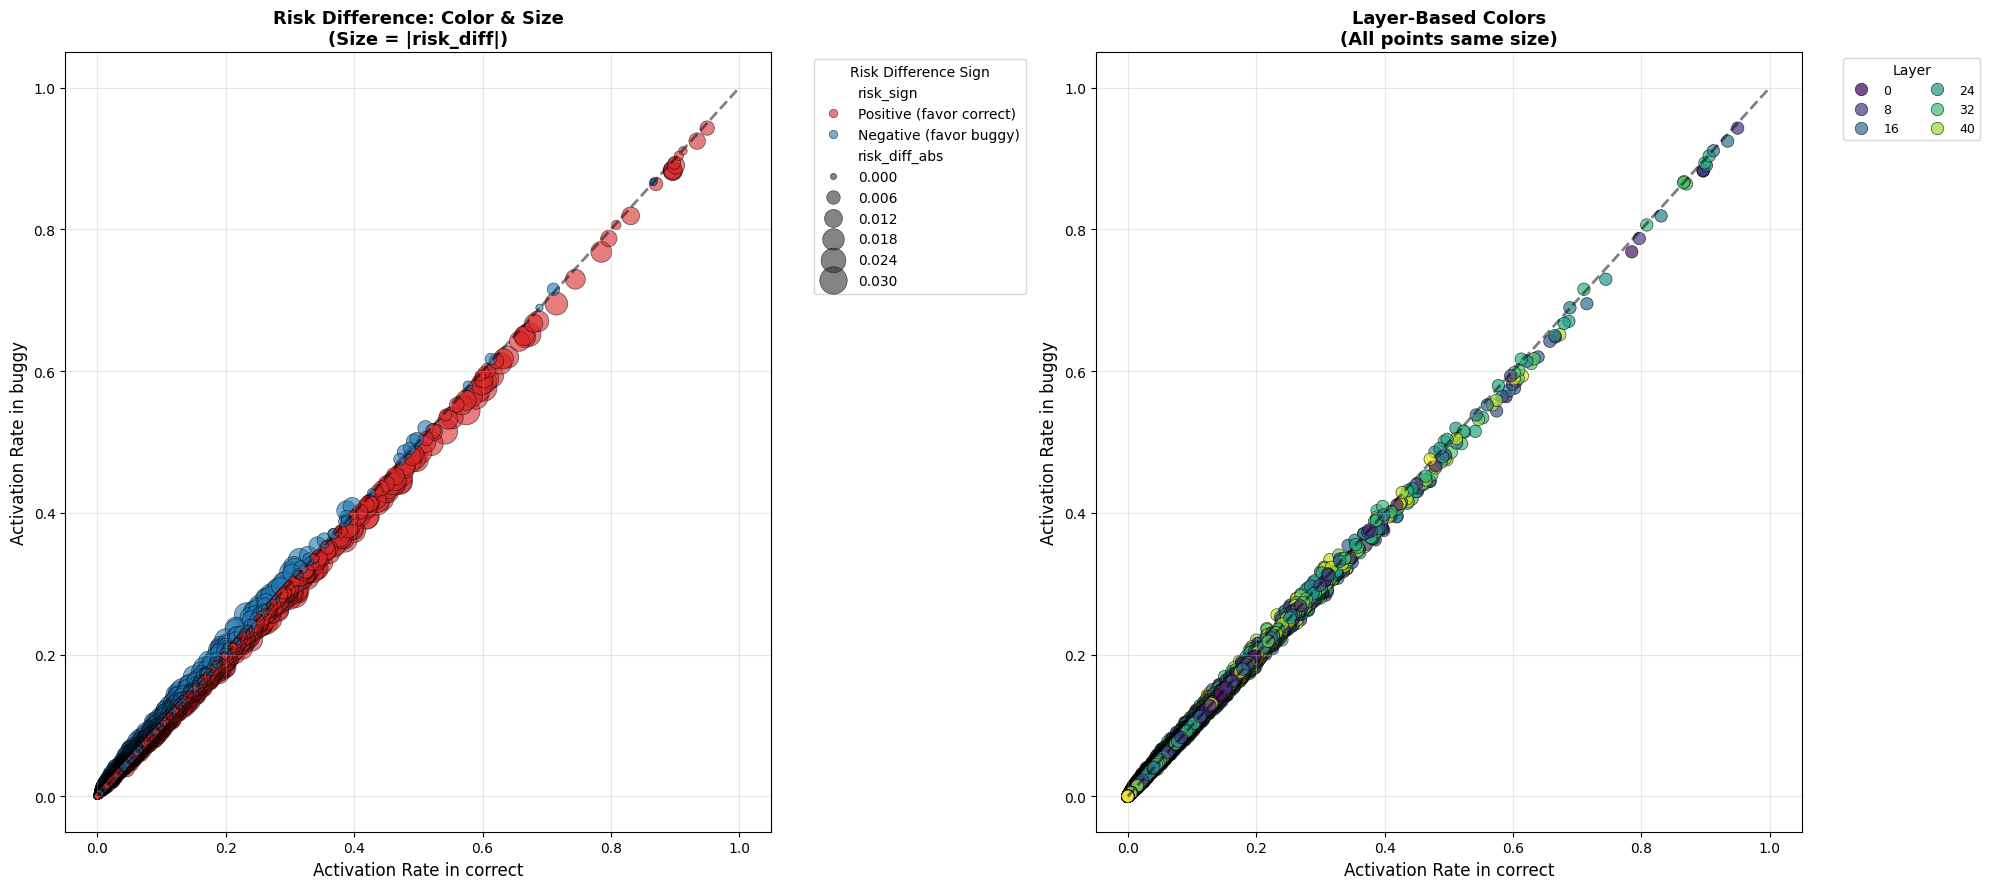

,layer,expert,a1,a2,d1,d2,a1_n,a2_n,risk_diff,risk_diff_abs
0,12,88,80436,76352,59576,64080,0.574494,0.543694,0.030800,0.030800
1,24,88,65930,62392,74082,78040,0.470888,0.444286,0.026602,0.026602
2,13,22,84326,80853,55686,59579,0.602277,0.575745,0.026532,0.026532
3,28,61,75779,72316,64233,68116,0.541232,0.514954,0.026278,0.026278
4,16,61,65802,62431,74210,78001,0.469974,0.444564,0.025410,0.025410
5,2,26,82485,79194,57527,61238,0.589128,0.563931,0.025197,0.025197
6,25,46,58749,55473,81263,84959,0.419600,0.395017,0.024583,0.024583
7,21,3,58603,55366,81409,85066,0.418557,0.394255,0.024302,0.024302
8,7,81,43122,39842,96890,100590,0.307988,0.283710,0.024278,0.024278
9,22,79,55823,52649,84189,87783,0.398702,0.374907,0.023794,0.023794


In [24]:
df_last = process_activation_counts(freq_all[CORRECT], freq_all[BUGGY], plot_diffs=True)

df_last.head(10)

Saved to activations_[Qwen--Qwen3-30B-A3B]_[calibri]_[all]_[428]_[140012].pkl


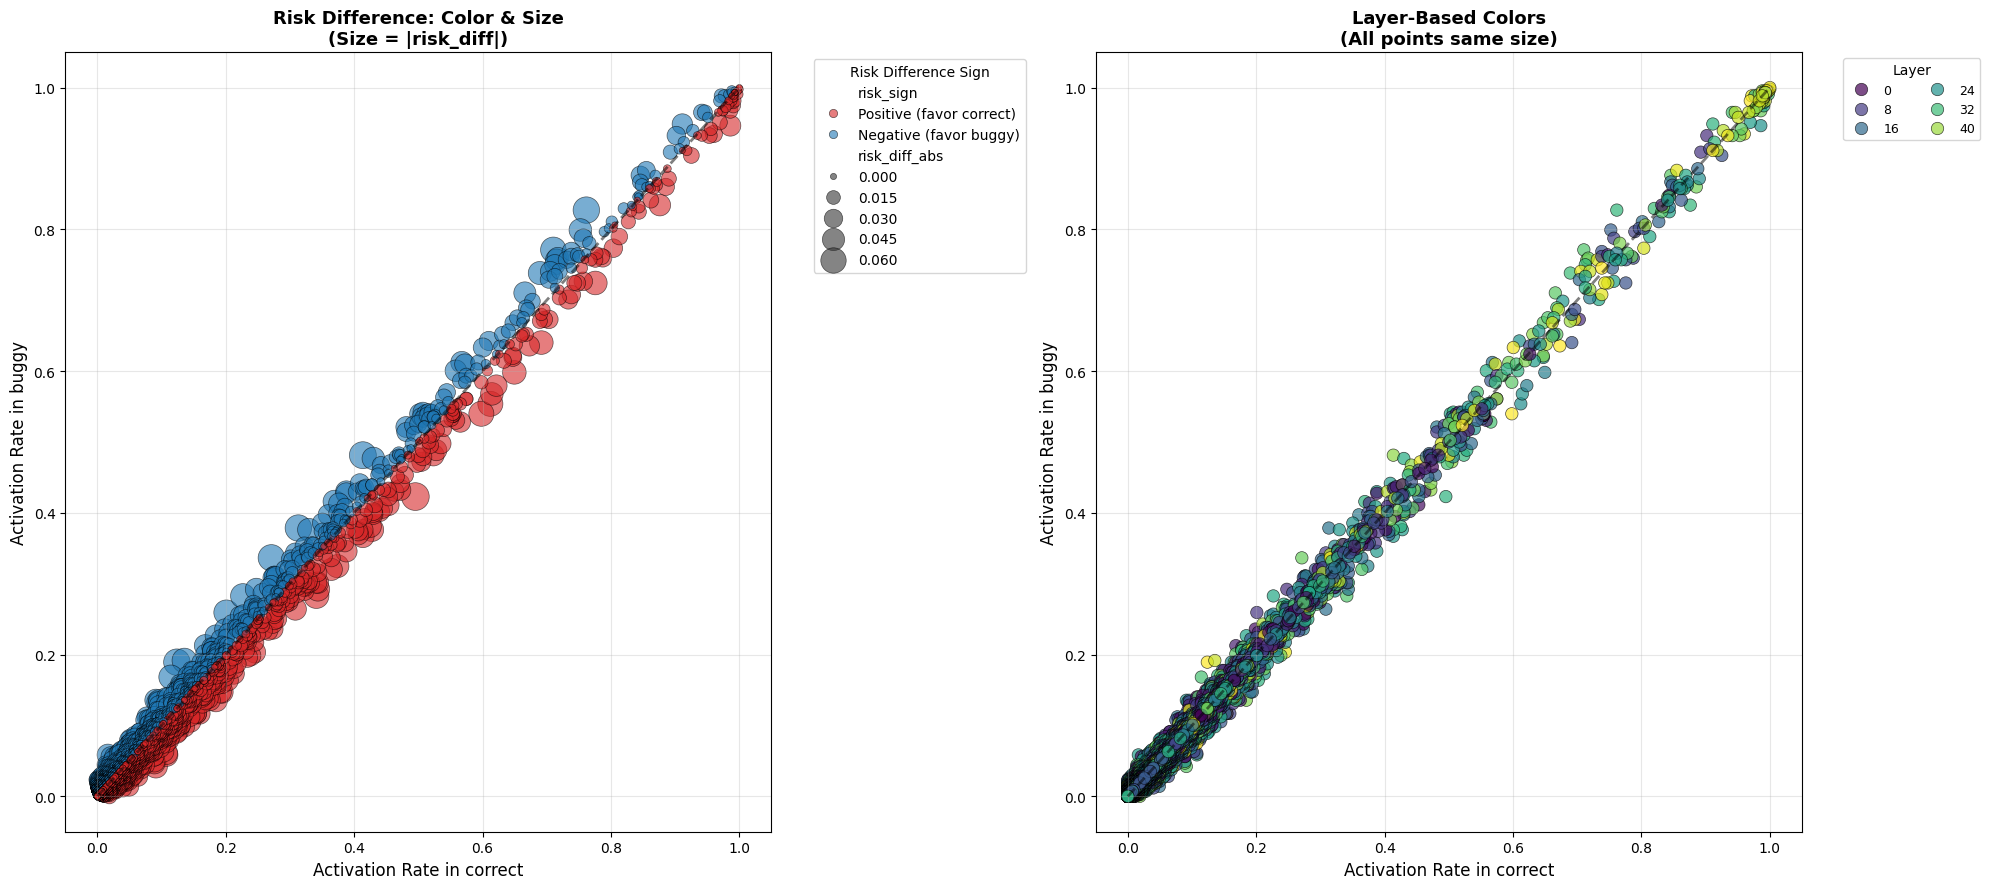

,layer,expert,a1,a2,d1,d2,a1_n,a2_n,risk_diff,risk_diff_abs
0,30,121,212,181,216,247,0.495327,0.422897,0.072430,0.072430
1,39,10,177,206,251,222,0.413551,0.481308,-0.067757,0.067757
2,47,116,53,81,375,347,0.123832,0.189252,-0.065421,0.065421
3,36,65,116,144,312,284,0.271028,0.336449,-0.065421,0.065421
4,18,122,134,162,294,266,0.313084,0.378505,-0.065421,0.065421
5,31,112,326,354,102,74,0.761682,0.827103,-0.065421,0.065421
6,34,68,304,330,124,98,0.710280,0.771028,-0.060748,0.060748
7,34,115,146,121,282,307,0.341121,0.282710,0.058411,0.058411
8,23,70,262,237,166,191,0.612150,0.553738,0.058411,0.058411
9,47,74,256,231,172,197,0.598131,0.539720,0.058411,0.058411


In [26]:
df_last = process_activation_counts(freq_reduced[CORRECT], freq_reduced[BUGGY], plot_diffs=True)

df_last.head(10)

In [22]:
# Scatter plots: risk_diff colors/sizes and layer colors
def plot_a1n_vs_a2n(df, subset1, subset2):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Prepare data
    df_plot = df.copy()
    df_plot['risk_sign'] = df_plot['risk_diff'].apply(lambda x: 'Positive (favor correct)' if x >= 0 else 'Negative (favor buggy)')
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))
    
    # Left plot: colored by risk_diff sign, sized by risk_diff_abs
    sns.scatterplot(data=df_plot, x="a1_n", y="a2_n", 
                    size="risk_diff_abs",
                    sizes=(20, 400),
                    hue="risk_sign", 
                    palette={"Positive (favor correct)": "#d62728", "Negative (favor buggy)": "#1f77b4"},
                    alpha=0.6,
                    edgecolor='black',
                    linewidth=0.5,
                    ax=axes[0])
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    axes[0].set_xlabel(f"Activation Rate in {subset1}", fontsize=12)
    axes[0].set_ylabel(f"Activation Rate in {subset2}", fontsize=12)
    axes[0].set_title(f"Risk Difference: Color & Size\n(Size = |risk_diff|)", fontsize=13, fontweight='bold')
    axes[0].legend(title="Risk Difference Sign", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    axes[0].grid(alpha=0.3)
    
    # Right plot: colored by layer
    sns.scatterplot(data=df_plot, x="a1_n", y="a2_n", 
                    hue="layer",
                    palette="viridis",
                    alpha=0.7,
                    s=80,
                    edgecolor='black',
                    linewidth=0.5,
                    ax=axes[1])
    axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
    axes[1].set_xlabel(f"Activation Rate in {subset1}", fontsize=12)
    axes[1].set_ylabel(f"Activation Rate in {subset2}", fontsize=12)
    axes[1].set_title(f"Layer-Based Colors\n(All points same size)", fontsize=13, fontweight='bold')
    axes[1].legend(title="Layer", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
plot_a1n_vs_a2n(df, 'correct', 'buggy')


KeyError: 'risk_diff'

# 5. Steer MoE LLM using Detected Experts

In [1]:
### RESTART HERE TO FREE GPU MEMORY FOR THE NEXT STEPS

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
#os.environ["HF_HOME"] = "/mnt/localssd/.hfcache/"
os.environ["VLLM_ALLOW_INSECURE_SERIALIZATION"] = "1"
os.environ["VLLM_DISABLE_COMPILE_CACHE"] = "1"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TRUST_REMOTE_CODE"] = "true"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

import sys
import torch
import argparse
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm
from importlib import reload
from dotenv import load_dotenv
import huggingface_hub as hf_hub
from vllm import LLM, SamplingParams

from src.utils import register_vllm_models, steer_moe

INFO 02-11 09:39:13 [__init__.py:241] Automatically detected platform cuda.


In [2]:
MODEL = "Qwen/Qwen3-30B-A3B"
DATASET = "custom_dataset"
config = {
    "model": MODEL,
    "task": DATASET,
    "max_tokens": 64,

    "activations_path": f"activations_[{MODEL.replace('/', '--')}]_[{DATASET}]_[rd]_[1]_[29].pkl",
    "num_pos_experts": 0,  # Adjust these based on the model and task
    "num_neg_experts": 250,  # Adjust these based on the model and task
}
config

{'model': 'Qwen/Qwen3-30B-A3B',
 'task': 'custom_dataset',
 'max_tokens': 64,
 'activations_path': 'activations_[Qwen--Qwen3-30B-A3B]_[custom_dataset]_[rd]_[1]_[29].pkl',
 'num_pos_experts': 0,
 'num_neg_experts': 250}

In [3]:
register_vllm_models()

llm = LLM(
    model=MODEL, 
    max_seq_len_to_capture=4096, max_model_len=4096, 
    tensor_parallel_size=torch.cuda.device_count(), gpu_memory_utilization=0.95, max_num_seqs=1,
    enforce_eager=True,
    enable_prefix_caching=False,
    trust_remote_code=True,
)

WARNING 02-11 09:39:45 [registry.py:458] Model architecture Qwen3MoeForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm.qwen3_moe:Qwen3MoeForCausalLM.
WARNING 02-11 09:39:45 [registry.py:458] Model architecture MixtralForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm.mixtral:MixtralForCausalLM.
WARNING 02-11 09:39:45 [registry.py:458] Model architecture OlmoeForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm.olmoe:OlmoeForCausalLM.
WARNING 02-11 09:39:45 [registry.py:458] Model architecture Llama4ForConditionalGeneration is already registered, and will be overwritten by the new model class src.modeling_vllm.mllama4:Llama4ForConditionalGeneration.
WARNING 02-11 09:39:45 [registry.py:458] Model architecture GptOssForCausalLM is already registered, and will be overwritten by the new model class src.modeling_vllm.gpt_oss:GptOssForCausalLM.
WARNI

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 02-11 09:39:54 [__init__.py:711] Resolved architecture: Qwen3MoeForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 02-11 09:39:54 [__init__.py:1750] Using max model len 4096
INFO 02-11 09:39:57 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 02-11 09:39:57 [scheduler.py:269] max_num_batched_tokens (8192) exceeds max_num_seqs * max_model_len (4096). This may lead to unexpected behavior.
WARNING 02-11 09:39:57 [scheduler.py:269] max_num_batched_tokens (8192) exceeds max_num_seqs * max_model_len (4096). This may lead to unexpected behavior.
INFO 02-11 09:39:57 [__init__.py:3565] Cudagraph is disabled under eager mode
WARNING 02-11 09:39:59 [serial_utils.py:48] Allowing insecure serialization using pickle due to VLLM_ALLOW_INSECURE_SERIALIZATION=1
(EngineCore_0 pid=2590325) INFO 02-11 09:39:59 [core.py:636] Waiting for init message from front-end.
(EngineCore_0 pid=2590325) INFO 02-11 09:39:59 [core.py:74] Initializing a V1 LLM engine (v0.10.1.1) with config: model='Qwen/Qwen3-30B-A3B', speculative_config=None, tokenizer='Qwen/Qwen3-30B-A3B', skip_tokenizer_

(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48
(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48


(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) INFO 02-11 09:40:06 [weight_utils.py:297] Using model weights format ['*.safetensors']
(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) INFO 02-11 09:40:06 [weight_utils.py:297] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/16 [00:00<?, ?it/s]


(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) INFO 02-11 09:40:14 [default_loader.py:262] Loading weights took 8.18 seconds
(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) INFO 02-11 09:40:15 [default_loader.py:262] Loading weights took 8.22 seconds
(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) INFO 02-11 09:40:16 [gpu_model_runner.py:2007] Model loading took 28.4577 GiB and 9.577614 seconds
(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) INFO 02-11 09:40:16 [gpu_model_runner.py:2007] Model loading took 28.4577 GiB and 10.282745 seconds
(EngineCore_0 pid=2590325) (EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) (VllmWorker TP1 pid=2590349) WARNING 02-11 09:40:18 [fused_moe.py:727] Using default MoE config. Performance might be sub-optimal! Config file not found at ['/data/dok/viola/projects/calibration/SteerMoE/.venv/lib/python3.12/site-packages/vllm/model_executor/layers/fused_moe/configs/E=128,N=384,device_name=NVIDIA_RTX_6000_Ada_Generation

(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48
(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48


(EngineCore_0 pid=2590325) (EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) (VllmWorker TP0 pid=2590347) WARNING 02-11 09:49:09 [cudagraph_dispatcher.py:101] cudagraph dispatching keys are not initialized. No cudagraph will be used.
WARNING 02-11 09:49:09 [cudagraph_dispatcher.py:101] cudagraph dispatching keys are not initialized. No cudagraph will be used.


(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48
(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48
(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48
(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48
(EngineCore_0 pid=2590325) (VllmWorker TP0 pid=2590347) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48
(EngineCore_0 pid=2590325) (VllmWorker TP1 pid=2590349) update_moe_manual_args: UPDATED EXPERTS ROUTING WEIGHTS 48


In [4]:
batch_messages = [
    [
        {
            "role": "user", 
            "content": "Count to fifteen.",
        }
    ],
]

In [5]:
### Before Steering
paired_ttest_df = steer_moe(
    llm, config["activations_path"],
    num_pos_experts=0, num_neg_experts=0,
    steering_magnitude=1000, reverse_effect=0, strategy="risk_diff"
)
sampling_params = SamplingParams(temperature=0.0, top_p=1, top_k=1, min_p=0, max_tokens=config["max_tokens"], seed=0)
outputs = llm.chat(batch_messages, sampling_params, use_tqdm=True, chat_template_kwargs={"enable_thinking": False, "reasoning_effort": "low"},)
generations = [output.outputs[0].text for output in outputs]
print("### Before Steering:")
print(generations)

MAX EXPERTS: 1236 1005
##### Total Experts: 6144, Layers: 48, Experts: 128
##### Num Experts: 0, Steering Magnitude: 1000, Reverse Effect: 0, pos_num_experts: 0, neg_num_experts: 0, metric=risk_diff, strategy: risk_diff


INFO 02-11 09:49:09 [chat_utils.py:470] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

### Before Steering:
['1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15.']


In [6]:
### After Steering Towards Digits
paired_ttest_df = steer_moe(
    llm, config["activations_path"],
    num_pos_experts=config["num_pos_experts"], num_neg_experts=config["num_neg_experts"],
    steering_magnitude=1000, reverse_effect=0, strategy="risk_diff"
)
sampling_params = SamplingParams(temperature=0.0, top_p=1, top_k=1, min_p=0, max_tokens=config["max_tokens"], seed=0)
outputs = llm.chat(batch_messages, sampling_params, use_tqdm=True, chat_template_kwargs={"enable_thinking": False, "reasoning_effort": "low"},)
generations = [output.outputs[0].text for output in outputs]
print("### After Steering Towards Digits:")
print(generations)

MAX EXPERTS: 1236 1005
##### Total Experts: 6144, Layers: 48, Experts: 128
##### Num Experts: 250, Steering Magnitude: 1000, Reverse Effect: 0, pos_num_experts: 0, neg_num_experts: 250, metric=risk_diff, strategy: risk_diff




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

### After Steering Towards Digits:
['1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15.']


In [8]:
### After Steering Away from Digits
paired_ttest_df = steer_moe(
    llm, config["activations_path"],
    num_pos_experts=config["num_pos_experts"], num_neg_experts=config["num_neg_experts"],
    steering_magnitude=1000, reverse_effect=1, strategy="risk_diff"
)
sampling_params = SamplingParams(temperature=0.0, top_p=1, top_k=1, min_p=0, max_tokens=config["max_tokens"], seed=0)
outputs = llm.chat(batch_messages, sampling_params, use_tqdm=True, chat_template_kwargs={"enable_thinking": False, "reasoning_effort": "low"},)
generations = [output.outputs[0].text for output in outputs]
print("### After Steering Away from Digits:")
print(generations)

MAX EXPERTS: 1005 1236
##### Total Experts: 6144, Layers: 48, Experts: 128
##### Num Experts: 250, Steering Magnitude: 1000, Reverse Effect: 1, pos_num_experts: 0, neg_num_experts: 250, metric=risk_diff, strategy: risk_diff




Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

### After Steering Away from Digits:
['1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15.']
